In [42]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import pickle
import math
import random
import numpy as np
import itertools
import bisect
import math
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import sys
import time
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, \
    confusion_matrix, f1_score, average_precision_score
from iforest import IsolationTreeEnsemble, find_TPR_threshold
from scipy.fftpack import fft,ifft
from matplotlib.pylab import mpl
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from k_means_constrained import KMeansConstrained
from sklearn.metrics import mean_squared_error 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


In [43]:
cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df['diagnosis'] = cancer.target
df.loc[df.diagnosis==0,'diagnosis'] = -1
df.loc[df.diagnosis==1,'diagnosis'] = 0
df.loc[df.diagnosis==-1,'diagnosis'] = 1
df.to_csv("cancer.csv", index=False)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


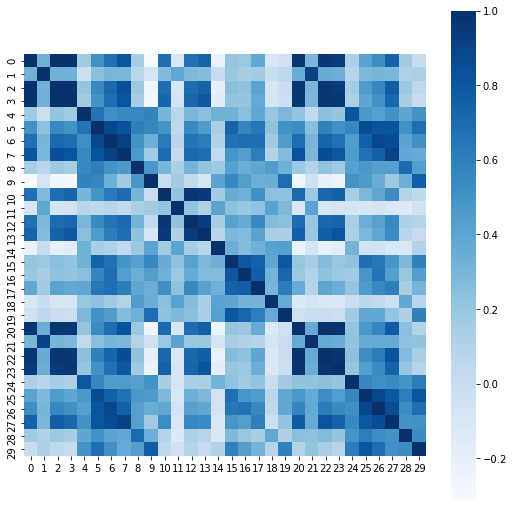

In [59]:
import seaborn as sns
x = df.values[:,0:30]
CORR = np.corrcoef(x.T)
plt.subplots(figsize=(9, 9))
sns.heatmap(CORR, annot=False, vmax=1, square=True, cmap="Blues")
plt.show()

In [3]:
def plot_anomalies(X, y, sample_size=256, n_trees = 100, 
                   desired_TPR=None, percentile = None, normal_ymax=None, bins=20):
    N = len(X)
    it = IsolationTreeEnsemble(sample_size=sample_size, n_trees=n_trees)
    fit_start = time.time()
    it.fit(X)
    fit_stop = time.time()
    fit_time = fit_stop - fit_start
    print(f"fit time {fit_time:3.2f}s")
    score_start = time.time()
    scores = it.anomaly_score(X)
    score_stop = time.time()
    score_time = score_stop - score_start
    print(f"score time {score_time:3.2f}s")
    if desired_TPR is not None:
        threshold, FPR = find_TPR_threshold(y, scores, desired_TPR)
        print(f"Computed {desired_TPR:.4f} TPR threshold {threshold:.4f} with FPR {FPR:.4f}")
    else:
        threshold = np.percentile(scores, percentile)
    y_pred = it.predict_from_anomaly_scores(scores, threshold=threshold)
    confusion = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = confusion.flat
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    normal = scores[y==0]
    anomalies = scores[y==1]
    F1 = f1_score(y, y_pred)
    PR = average_precision_score(y, scores)
    print('FScore : ',F1 )
    return None
class ANN:
    def __init__(self, X, Y, X_test, Y_test, hidden_nodes=12, learninig_rate=0.1, epochs=500):
        self.X = X
        self.Y = Y[:, None]
        self.X_test = X_test
        self.Y_test = Y_test

        # defining parameters

        np.random.seed(4)
        self.input_nodes = len(X[0])     # number of features in the training data
        self.hidden_nodes = hidden_nodes
        self.output_npdes = self.Y.shape[1]
        self.learning_rate = learninig_rate

        # initializing the weights for our network

        self.w1 = 2 * np.random.random((self.input_nodes, self.hidden_nodes)) - 1
        self.w2 = 2 * np.random.random((self.hidden_nodes, self.output_npdes)) - 1

        self.train(epochs)  # Since we have to train our model for many times we here pass epochs count
        self.test()
    
    def sigmoid(self,X):
        return (1 / (1 + np.exp(-X)))
    def sigmoid_prime(self, X):
        return X * (1 - X)



    def train(self, epochs):
        for e in range(epochs):
            # FORWARDPROPAGATION
            l1 = self.sigmoid(np.dot(self.X, self.w1))
            # in between hidden and output
            l2 = self.sigmoid(np.dot(l1, self.w2))

            # BACKPROPAGATION
            # Network error (True value - Predicted value)

            error = self.Y - l2

            # error for each of the layers

            l2_delta = error * self.sigmoid_prime(l2)
            l1_delta = l2_delta.dot(self.w2.T) * self.sigmoid_prime(l1)

            self.w2 = np.add(self.w2, l1.T.dot(l2_delta) * self.learning_rate)
            self.w1 = np.add(self.w1, self.X.T.dot(l1_delta) * self.learning_rate)

#         print('Error : ', (abs(error)).mean())

    # testing and evaluation


    def test(self):
        correct = 0
        pred_list = []
        l1 = self.sigmoid(np.dot(self.X_test, self.w1))
        l2 = self.sigmoid(np.dot(l1, self.w2))

        for i in range(len(l2)):
            if l2[i] >= 0.5:
                pred = 1
            else:
                pred = 0

            if pred == self.Y_test[i]:
                correct += 1

            pred_list.append(pred)
#         print('Test Accuracy : ', ((correct / len(Y_test)) * 100), '%')



        precision, recall,fscore, support =  precision_recall_fscore_support(Y_test, pred_list)

        tn, fp, fn, tp = confusion_matrix(Y_test, pred_list).ravel()
#         print('True Nagative', tn)
#         print('False Positive', fp)
#         print('False Negative', fn)
#         print('True Positive', tp)

        total = tn + tp + fn + fp

#         print('Test Accuracy : ', (tn + tp)/total)
#         print('FScore : ', (fscore[0]+fscore[1])/2)
        return (fscore[0]+fscore[1])/2

    def fm_test(self,X,Y):
        correct = 0
        pred_list = []
        l1 = self.sigmoid(np.dot(X, self.w1))
        l2 = self.sigmoid(np.dot(l1, self.w2))

        for i in range(len(l2)):
            if l2[i] >= 0.5:
                pred = 1
            else:
                pred = 0

            if pred == self.Y[i]:
                correct += 1

            pred_list.append(pred)
        precision, recall,fscore, support =  precision_recall_fscore_support(Y, pred_list)

        tn, fp, fn, tp = confusion_matrix(Y, pred_list).ravel()
        return (fscore[0]+fscore[1])/2